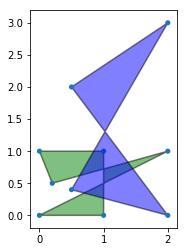

In [119]:
import matplotlib.pyplot as plt

% matplotlib inline

def show_polygons(ax, polygons, face_color='white', alpha=1):
    from matplotlib.patches import Polygon, Circle
    patches = []

    if isinstance(face_color, list):
        def get_face_color():
            np.random.shuffle(face_color)
            return face_color[0]
    else:
        def get_face_color():
            return face_color

    for vertices in polygons:
        polygon = Polygon(
            vertices,
            alpha=alpha, 
            ec='black',
            fc=get_face_color(),
            lw=1.5)
        patches.append(polygon)
        for vertex in vertices:
            circle = Circle(vertex, 0.04)
            patches.append(circle)

    for patch in patches:
        ax.add_patch(patch)

    ax.autoscale()
    ax.set_aspect('equal')

fig, ax = plt.subplots()
s = [[0, 0], [1, 0], [1, 1], [0, 1], [0.2, 0.5], [2, 1]]
c = [[0.5, 2], [2, 0], [0.5, 0.4], [2, 3]]
show_polygons(ax, [s], 'green', 0.5)
show_polygons(ax, [c], 'blue', 0.5)

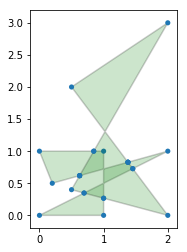

In [121]:
import numpy as np 
import copy

def to_gh_point(x, y):
    return {'x': x, 'y': y}

def to_gh_polygon(poly):
    first = None
    current = first
    for x, y in poly:
        if first is None:
            current = first = to_gh_point(x, y)
            first['first'] = True
        else:
            current['next'] = to_gh_point(x, y)
            current = current['next']
    current['next'] = first
    return first

def intersect(p1, p2, q1, q2):
    p1, p2, q1, q2 = map(np.array, [p1, p2, q1, q2])
    wec_p1 = np.cross(p1 - q1, q2 - q1)
    wec_p2 = np.cross(p2 - q1, q2 - q1)
    if wec_p1 * wec_p2 < 0:
        wec_q1 = np.cross(q1 - p1, p2 - p1)
        wec_q2 = np.cross(q2 - p1, p2 - p1)
        if wec_q1 * wec_q2 < 0:
            p_alpha = wec_p1 / (wec_p1 - wec_p2)
            q_alpha = wec_q1 / (wec_q1 - wec_q2)
            return True, p_alpha, q_alpha
    return False, None, None

def gh_polygon_iter(poly):
    while True:
        yield poly
        poly = poly['next']
        if 'first' in poly:
            yield poly
            break
                        
def gh_polygon_iter_point(poly):
    return map(lambda v: (v['x'], v['y']), gh_polygon_iter(poly))
        
def create_vertex(p1, p2, alpha):
    p1, p2 = map(np.array, [p1, p2])
    x, y = p1 + (p2 - p1) * alpha
    return to_gh_point(x, y)

def gh_polygon_to_points(gh):
    return list(gh_polygon_iter_point(gh))

def phase_one(s, c):
    s = copy.deepcopy(s)
    c = copy.deepcopy(c)
    cur_s = s
    cur_c = c
    for cur_s in gh_polygon_iter(s):
        for cur_c in gh_polygon_iter(c):
            p1, p2 = map(lambda v: (v['x'], v['y']), [cur_s, cur_s['next']])
            q1, q2 = map(lambda v: (v['x'], v['y']), [cur_c, cur_c['next']])
            b, p_alpha, q_alpha = intersect(p1, p2, q1, q2)
            if b:
                si = create_vertex(p1, p2, p_alpha)
                ci = create_vertex(q1, q2, q_alpha)
                si['neighbor'] = ci
                ci['neighbor'] = si
                si['next'] = cur_s['next']
                cur_s['next'] = si
                ci['next'] = cur_c['next']
                cur_c['next'] = ci
    return s, c

gh_s = to_gh_polygon(a)
gh_c = to_gh_polygon(b)

gh_s1, gh_c1 = phase_one(gh_s, gh_c)

fig, ax = plt.subplots()
show_polygons(ax, map(get_xys, [gh_s1, gh_c1]), 'green', 0.2)

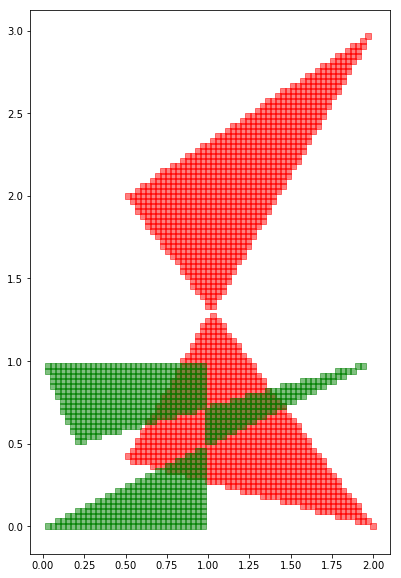

In [122]:
def is_left(a, b, p):
    a, b, p = map(np.array, (a, b, p))
    return np.cross(b - a, p - a) > 0

def winding_number(p, poly):
    wn = 0
    ps = gh_polygon_to_points(poly)
    for v1, v2 in zip(ps[:-1], ps[1:]):
        if v1[1] <= p[1]:
            if v2[1] > p[1] and is_left(v1, v2, p): # upward crossing and left
                wn += 1
        elif v2[1] <= p[1] and not is_left(v1, v2, p):
            wn -= 1
    return wn

def inside(p, poly):
    return winding_number(p, poly) % 2 != 0


def plot_inside(ax, gh_polygon, color='blue', alpha=0.5):
    ps = []
    for i in np.linspace(0, 3, 100):
        for j in np.linspace(0, 3, 100):
            if inside([i, j], gh_polygon):
                ps.append([i, j])
    ax.scatter(*zip(*ps), color=color, alpha=alpha, marker='s')
    ax.set_aspect('equal')

fig, ax = plt.subplots(figsize=(10, 10))
plot_inside(ax, gh_c, 'red')
plot_inside(ax, gh_s, 'green')

In [125]:
def assign_status(a, b):
    '''
    assign a according to b
    '''
    def toggle(status):
        if status == 'exit':
            return 'entry'
        return 'exit'
    p0 = a['x'], a['y']
    if inside(p0, b):
        status = 'exit'
    else:
        status = 'entry'
    for v in gh_polygon_iter(a):
        if 'neighbor' in v:
            v['status'] = status
            status = toggle(status)

def phase_two(s, c):
    s = copy.deepcopy(s)
    c = copy.deepcopy(c)
    assign_status(s, c)
    assign_status(c, s)
    return s, c

gh_s2, gh_c2 = phase_two(gh_s1, gh_c1)